### Factors Driving Life Expectancy : Do immunization matters?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
#MICE performe multiple regression for imputing / it is a very robost model for imputation
from fancyimpute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,  f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import os

from library.sb_utils import save_file

In [2]:
sns.set()
sns.set_context("notebook")

### Import dataset 

In [3]:
df = pd.read_csv("../data/life_exp_clean.csv")

In [4]:
df.head(2)

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,year,population
0,Afghanistan,2015-01-01,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,2015,17.334091
1,Afghanistan,2014-01-01,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,2014,12.699494


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2928 non-null   object 
 1   Year                             2928 non-null   object 
 2   Status                           2928 non-null   object 
 3   Life_expectancy                  2928 non-null   float64
 4   Adult_Mortality                  2928 non-null   float64
 5   infant_deaths                    2090 non-null   float64
 6   Alcohol                          2735 non-null   float64
 7   percentage_expenditure           2322 non-null   float64
 8   Hepatitis_B                      2375 non-null   float64
 9   Measles                          1955 non-null   float64
 10  BMI                              2896 non-null   float64
 11  under_five_deaths                2153 non-null   float64
 12  Polio               

In [6]:
# convert Year to datetime object 
#df1.Year = pd.to_datetime(df1.Year, format='%Y-%d-%m')
#df1['year']=df1['Year'].dt.year

### Label Encoder categerical variable

In [7]:
# copy the data
#df = df1.copy(deep=True)

In [8]:
df = df.drop(columns=['Country', 'Year'])

In [9]:
# one hot_encoder
df = pd.get_dummies(df)
#df.insert(0,'Country', df1['Country'], allow_duplicates=True)

In [10]:
df.columns

Index(['Life_expectancy', 'Adult_Mortality', 'infant_deaths', 'Alcohol',
       'percentage_expenditure', 'Hepatitis_B', 'Measles', 'BMI',
       'under_five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness__1_19_years',
       'thinness_5_9_years', 'Income_composition_of_resources', 'Schooling',
       'year', 'population', 'Status_Developed', 'Status_Developing'],
      dtype='object')

In [11]:
# define X and y
X = df.drop(columns='Life_expectancy')
y = df.Life_expectancy

In [12]:
# split the dataset     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [13]:
X_train.shape, X_test.shape

((2049, 22), (879, 22))

In [14]:
# traitement of missing data with MICE Imputation
mice_imputer = IterativeImputer()
X_train_imput = mice_imputer.fit_transform(X_train)
X_test_imput = mice_imputer.transform(X_test)

In [15]:
# scale the date
scaler = StandardScaler()
X_train_imput_scale = scaler.fit_transform(X_train_imput)
X_test_imput_scale = scaler.transform(X_test_imput)

In [16]:
# dimentionnality reduction
pca = PCA()
X_train_pca = pca.fit(X_train_imput_scale)
X_train_pcat = pca.transform(X_train_imput_scale)

###  Modeling


##### Function to evaluate the model

In [17]:
def model_eval(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

### 1. Model linear_regression 

In [18]:
pipe = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [19]:
# define the k range to investigate
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [20]:
reg_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [21]:
reg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000264CF6FFC10>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22]})

In [22]:
#Print the `best_params_` attribute of 'red_grid_cv`
reg_grid_cv.best_params_

{'selectkbest__k': 20}

In [23]:
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]
best_k = reg_grid_cv.best_params_['selectkbest__k']

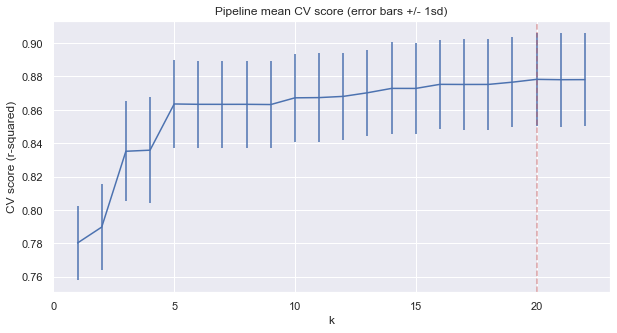

In [24]:
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 20

In [25]:
# mask to select the most useful features 
selected_features= reg_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [26]:
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_[0]
features = X_train.columns[selected_features]
pd.Series(coefs, index=features).sort_values(ascending=False)

Adult_Mortality                   -1.621094
infant_deaths                     -1.621094
Status_Developed                  -1.621094
year                              -1.621094
Schooling                         -1.621094
Income_composition_of_resources   -1.621094
thinness_5_9_years                -1.621094
thinness__1_19_years              -1.621094
GDP                               -1.621094
HIV/AIDS                          -1.621094
Diphtheria                        -1.621094
Total_expenditure                 -1.621094
Polio                             -1.621094
under_five_deaths                 -1.621094
BMI                               -1.621094
Measles                           -1.621094
Hepatitis_B                       -1.621094
percentage_expenditure            -1.621094
Alcohol                           -1.621094
Status_Developing                 -1.621094
dtype: float64

#### Note:
From this result, the best positive features here are Income_composition_of_resources , followed by infant_deaths. 

Features which negatively influence life expectancy are under_five_deaths of children (the most important) , next it is HIV/AIDS and Adult_Mortality.

We realise that immunization factors are also present among the positive features (come in 6th , 7th and 8th positions) even if their strength is not high as compared to the first features. 

It is also important to highlight the fact that the feature: status of the country (either developed or developing) has an impact on the model. 
May, it would be great to expect if a dataset with only developing countries would highlight the importance of immunization as we explore in the EDA.


In [27]:
reg_grid_cv.best_estimator_

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000264CF6FFC10>)),
                ('linearregression', LinearRegression())])

In [28]:
lin_reg = reg_grid_cv.best_estimator_

In [29]:
#lin_reg.get_params()

#### Assess performance on train and test data

In [30]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4212886814180403
MSE: 11.085552730875424
RMSE: 3.329497369104746
R2 Square 0.876189164368797
__________________________________
MAE: 2.435270080792682
MSE: 10.83356220569479
RMSE: 3.291437711045857
R2 Square 0.881096600191585
__________________________________


#### Assessing performance using cross-validation

In [31]:
cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train, cv=5)

In [32]:
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.8793952573076768, 0.013289807834014365)

### 2. Model linear regression with PCA

In [33]:
pipe3 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    PCA(n_components=19),
    LinearRegression())

In [34]:
lin_reg2 = pipe3.fit(X_train, y_train)

In [35]:
#lin_reg2.get_params()

#### Model Evaluation

In [36]:
predicted_train = lin_reg2.predict(X_train)
predicted_test = lin_reg2.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.675249479702949
MSE: 12.880212035486206
RMSE: 3.5889012295528846
R2 Square 0.8561452140515242
__________________________________
MAE: 2.7194090027919087
MSE: 12.856261217066843
RMSE: 3.5855628870606693
R2 Square 0.8588965348137508
__________________________________


### 3. Model: Ridge regression 

In [37]:
###select the best value of alpha

In [38]:
# Perform 5-fold cross-validation: ridge_cv
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
for x in alpha:
    ridge = Ridge(alpha=10)
    ridge_cv = cross_val_score(ridge, X_train_imput_scale, y_train, cv=10, n_jobs=-1)
    print( 'cross-validated scores of ridge regression for alpha', x ,'is :', np.mean(ridge_cv))

cross-validated scores of ridge regression for alpha 1e-05 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 0.0001 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 0.001 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 0.01 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 0.1 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 0.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 1.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 10.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 20.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 40.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 60.0 is : 0.8760049691596301
cross-validated scores of ridge regression for alpha 80.0 is : 0.8760049691596301
cross-validated

##### use of GridSearchCV (it doesn't work ????)

In [39]:
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
grid

{'alpha': [1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  0.0,
  1.0,
  10.0,
  20.0,
  40.0,
  60.0,
  80.0,
  100.0]}

In [40]:
pipe4 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge())

In [41]:
ridge_grid_cv = GridSearchCV(pipe4, grid, cv=10, n_jobs=-1)

#####  Model: Ridge regression 

In [42]:
pipe5 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge(alpha=0.5))

In [43]:
ridge_reg = pipe5.fit(X_train, y_train)

In [44]:
predicted_train = ridge_reg.predict(X_train)
predicted_test = ridge_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.419506794751066
MSE: 11.080545925998873
RMSE: 3.3287453981941715
R2 Square 0.8762450837000796
__________________________________
MAE: 2.436158911517165
MSE: 10.830899456128812
RMSE: 3.2910331897640916
R2 Square 0.8811258251104271
__________________________________


In [45]:
#ridge_reg.get_params()

### 4.ElasticNet regression

In [46]:
#  hyperparameter grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1.1, 0.1)

In [47]:
grid

{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

###### identify the best parameters

In [48]:
elastic_net = ElasticNet()

EL_grid_cv0 = GridSearchCV(elastic_net, grid, cv=5, n_jobs=-1)

EL_grid_cv0 .fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11094.221607937608, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0,
                                   10.0, 100.0],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [49]:
print("Tuned ElasticNet l1 ratio: {}".format(EL_grid_cv0.best_params_))

Tuned ElasticNet l1 ratio: {'alpha': 0.0, 'l1_ratio': 0.0}


##### Run the model with the best paramters and assessing the performance

In [50]:
elastic_net = ElasticNet(alpha = 0.0001, l1_ratio = 0.4)

elastic_net_CV = cross_val_score(elastic_net, X_train_imput_scale, y_train, cv=10, n_jobs=-1)

print( 'cross-validation scores of elastic_net regression is ', np.mean(elastic_net_CV))

cross-validation scores of elastic_net regression is  0.8777323160141446


In [51]:
Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7593.627533618658, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


In [52]:
predicted_train = Elastic_net.predict(X_train_imput_scale)
predicted_test = Elastic_net.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.420088282485302
MSE: 11.087236463584864
RMSE: 3.329750210388891
R2 Square 0.8761703593205693
__________________________________
MAE: 2.435186839332167
MSE: 10.829141305545864
RMSE: 3.2907660666698666
R2 Square 0.881145121633373
__________________________________


### 5.  Decision tree for regression

In [53]:
param_rf={'max_depth':[4,6,8, 10, 12, 14, 16], 'min_samples_leaf': [0.1, 0.2, 0.5, 1, 1.5, 2], 
          'max_features': [0.2,0.4, 0.6, 0.8, 1.0]}

In [54]:
dt = DecisionTreeRegressor(random_state=1)
dt_grid_CV= GridSearchCV(estimator= dt ,param_grid=param_rf, cv=10,
                          scoring='accuracy',  n_jobs=-1)
# Fit dt to the training set
dt_grid_CV=dt_grid_CV.fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warni

In [55]:
best_dt_param = dt_grid_CV.best_params_
best_dt_param

{'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 0.1}

In [56]:
model_dt = dt_grid_CV.best_estimator_

In [57]:
predicted_train = dt_grid_CV.predict(X_train_imput_scale)
predicted_test = dt_grid_CV.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 3.9071967857517733
MSE: 27.131060903630484
RMSE: 5.2087484968685605
R2 Square 0.696982243142126
__________________________________
MAE: 3.6766344533719293
MSE: 23.010452650562694
RMSE: 4.796921163680167
R2 Square 0.7474495462033497
__________________________________


In [58]:
#### experimentation, Use of X_train and X_test (just the missing data imputation, no_scaling)

In [59]:
#model_dt.fit(X_train_imput, y_train)

In [60]:
#predicted_train = model_dt.predict(X_train_imput_scale)
#predicted_test = model_dt.predict(X_test_imput_scale)
#model_eval(y_test, predicted_test)
#model_eval(y_train, predicted_train)

### 6.Random Forest Model

https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb

#### Simple model of random forest 

In [61]:
rf_reg1 = RandomForestRegressor(n_estimators = 200, max_depth= 4, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg1.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=4, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [62]:
#### evaluate the model

In [63]:
predicted_train = rf_reg1.predict(X_train_imput_scale)
predicted_test = rf_reg1.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.079883491429767
MSE: 8.354804191402206
RMSE: 2.890467815320248
R2 Square 0.9066879826757275
__________________________________
MAE: 1.9806380039566067
MSE: 7.391979562657916
RMSE: 2.718819516381681
R2 Square 0.9188695754336162
__________________________________


#### 2nd model of random forest 

In [64]:
rf_reg2 = RandomForestRegressor(n_estimators = 200, max_depth= 10, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg2.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=10, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [65]:
# evaluate the model
predicted_train = rf_reg2.predict(X_train_imput_scale)
predicted_test = rf_reg2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.348903715319932
MSE: 4.03797906285001
RMSE: 2.0094723344326018
R2 Square 0.9549011606213991
__________________________________
MAE: 0.7557958217192339
MSE: 1.2251327362814532
RMSE: 1.1068571435742975
R2 Square 0.9865535966107365
__________________________________


In [66]:
##### random forest model

In [67]:
rf_reg3 = RandomForestRegressor(n_estimators = 100, max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)
rf_reg3.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)

In [68]:
# evaluate the model
predicted_train = rf_reg3.predict(X_train_imput_scale)
predicted_test = rf_reg3.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.6356661799477743
MSE: 5.450426307247203
RMSE: 2.3346148091809926
R2 Square 0.9391260091373651
__________________________________
MAE: 1.3116043430038709
MSE: 3.320191214437195
RMSE: 1.8221391863513596
R2 Square 0.9635593523242899
__________________________________


#### 4th model of random forest with GridSearchCV

In [69]:
param_rf={'max_depth':[4, 5, 6, 7, 8],'n_estimators':[50, 75, 100, 150, 175, 200], 
          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1], 'max_features': [0.3, 0.4, 0.5, 0.6]},

In [70]:
# Perform Grid-Search
RF_grid_CV= GridSearchCV(estimator= RandomForestRegressor(random_state=1) ,param_grid=param_rf, cv=5, 
                          scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [71]:
RF_grid_CV.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-17.33351573 -16.96519845 -16.8866428  -16.98223729 -16.79765069
 -16.81141697 -28.36071026 -27.44499646 -27.23311193 -27.09267581
 -26.85588028 -26.73330195 -91.12647702 -91.12889565 -91.12945785
 -91.13285487 -91.13255861 -91.13252833          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -9.12273586  -9.09423923  -9.10465821  -9.17214039  -9.08905544
  -9.11274354 -15.92639105 -15.70711944 -15.58556038 -15.71511524
 -15.65801208 -15.71398972 -24.83535406 -24.71688427 -24.65624866
 -25.05022262 -24.75280321 -24.71299411 -91.12647702 -91.12889565
 -91.12945785 -91.13285487 -91.13255861 -91.13252833          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=({'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [0.3, 0.4, 0.5, 0.6],
                          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
                          'n_estimators': [50, 75, 100, 150, 175, 200]},),
             scoring='neg_mean_squared_error', verbose=1)

In [72]:
best_rf_param = RF_grid_CV.best_params_
best_rf_param

{'max_depth': 8,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [73]:
rf_reg4 = RF_grid_CV.best_estimator_

In [74]:
predicted_train = rf_reg4.predict(X_train_imput_scale)
predicted_test = rf_reg4.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.439830494690462
MSE: 4.468102721716352
RMSE: 2.113788712647589
R2 Square 0.950097253146342
__________________________________
MAE: 0.9869440578810267
MSE: 2.0130210826019947
RMSE: 1.4188097415094085
R2 Square 0.9779061544058358
__________________________________


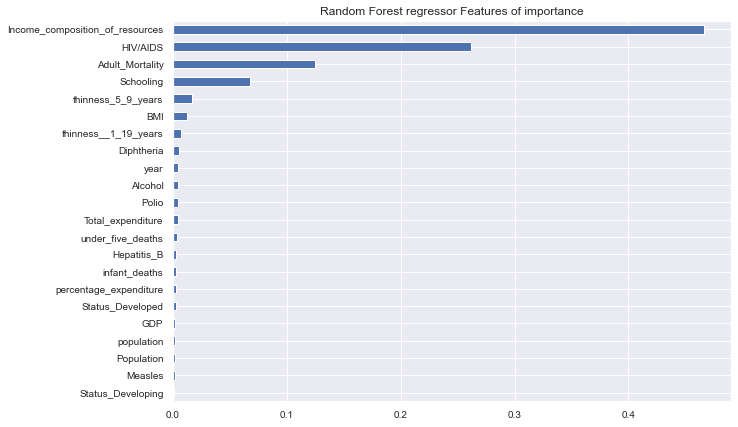

In [75]:
Important_features =  pd.Series(rf_reg4.feature_importances_, index = X_train.columns).sort_values()
Important_features.plot(kind='barh', figsize=(10,7) , fontsize=10)
plt.title('Random Forest regressor Features of importance')
plt.show()

In [76]:
# Perform K-Fold CV for Random forest regressor 
scores = cross_val_score(rf_reg4, X_train_imput_scale, y_train, cv= 5)

In [77]:
np.mean(scores)

0.9503539246037436

In [78]:
scores2 = cross_validate(rf_reg4, X_train_imput_scale, y_train, cv=5)

In [79]:
scores2 = cv_results['test_score']
np.mean(scores2), np.std(scores2)

(0.8793952573076768, 0.013289807834014365)

In [80]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]}


In [81]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_imput_scale, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=2)

In [82]:
rf_random.best_params_

{'n_estimators': 633,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.4,
 'max_depth': 40,
 'bootstrap': False}

In [83]:
rf_reg6 = rf_random.best_estimator_

In [84]:
predicted_train = rf_reg6.predict(X_train_imput_scale)
predicted_test = rf_reg6.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.0981932290571448
MSE: 3.1907051007938194
RMSE: 1.7862544893698153
R2 Square 0.9643640804953505
__________________________________
MAE: 4.297309756020651e-13
MSE: 3.0131734921725817e-25
RMSE: 5.489238100294595e-13
R2 Square 1.0
__________________________________


In [85]:
# Perform K-Fold CV
rf_scores = cross_val_score(rf_random.best_estimator_, X_train_imput_scale, y_train, cv=5)

In [86]:
 np.mean(rf_scores), np.std(rf_scores)

(0.9610145660730247, 0.007460624123182943)

##### 1st Gradien Boosting Model 

In [87]:
grdB = GradientBoostingRegressor(n_estimators = 150, max_depth = 3, random_state=1)
grdB.fit(X_train_imput_scale, y_train)

GradientBoostingRegressor(n_estimators=150, random_state=1)

In [88]:
predicted_train = grdB.predict(X_train_imput_scale)
predicted_test = grdB.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.547262265790735
MSE: 4.977193003181032
RMSE: 2.2309623491177595
R2 Square 0.9444113938400835
__________________________________
MAE: 1.1459256178294823
MSE: 2.5811680572595215
RMSE: 1.6066013996195576
R2 Square 0.9716704762793804
__________________________________


#### 2nd Gradient Boost Model

In [89]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 150, num = 5)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [6, 8, 10, 12]
min_samples_leaf = [4, 6, 8, 10]
learning_rate = [x for x in np.linspace(0.01, 0.3, num = 5)]
criterion = ['mse',]


grd_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate}
print(grd_grid)

{'n_estimators': [25, 56, 87, 118, 150], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [6, 8, 10, 12], 'min_samples_leaf': [4, 6, 8, 10], 'learning_rate': [0.01, 0.08249999999999999, 0.155, 0.22749999999999998, 0.3]}


In [90]:
# with RandomizedSearchCV
grd = GradientBoostingRegressor()

grd_Boost = RandomizedSearchCV(estimator = grd, param_distributions= grd_grid,  cv = 5, verbose=1, random_state=1, n_jobs = -1)

In [91]:
# with GridSearchCV
grd = GradientBoostingRegressor(random_state = 1)

grd_Boost2 = GridSearchCV(estimator = grd, param_grid= grd_grid, scoring='neg_mean_squared_error', cv = 5, verbose=1, n_jobs = -1)

In [92]:
grd_Boost.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01,
                                                          0.08249999999999999,
                                                          0.155,
                                                          0.22749999999999998,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [4, 6, 8, 10],
                                        'min_samples_split': [6, 8, 10, 12],
                                        'n_estimators': [25, 56, 87, 1

In [93]:
grd_Boost2.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.08249999999999999, 0.155,
                                           0.22749999999999998, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.6000000000000001, 0.8,
                                          1.0],
                         'min_samples_leaf': [4, 6, 8, 10],
                         'min_samples_split': [6, 8, 10, 12],
                         'n_estimators': [25, 56, 87, 118, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [94]:
grd_Boost.best_params_

{'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

#grd_Boost.best_params_ = {'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

In [95]:
grd_Boost2.best_params_

{'learning_rate': 0.08249999999999999,
 'max_depth': 10,
 'max_features': 0.6000000000000001,
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 118}

#grd_Boost2.best_params_ = {'learning_rate': 0.08249999999999999,
 'max_depth': 7,
 'max_features': 0.8,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 150}

In [96]:
grd_Boost.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=10, n_estimators=118)

In [97]:
grd_Boost2.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=118,
                          random_state=1)

In [98]:
GRD_Boost= grd_Boost.best_estimator_

In [99]:
GRD_Boost2= grd_Boost2.best_estimator_

In [100]:
predicted_train = GRD_Boost.predict(X_train_imput_scale)
predicted_test = GRD_Boost.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1519509741538532
MSE: 3.322830358211789
RMSE: 1.8228632308025166
R2 Square 0.9628884176280091
__________________________________
MAE: 0.1853471175132328
MSE: 0.10111564274350664
RMSE: 0.317986859388099
R2 Square 0.9988902086434972
__________________________________


In [101]:
predicted_train = GRD_Boost2.predict(X_train_imput_scale)
predicted_test = GRD_Boost2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1524694564048448
MSE: 3.42181058493487
RMSE: 1.8498136622197572
R2 Square 0.9617829405373253
__________________________________
MAE: 0.18419439450246006
MSE: 0.09993145286042204
RMSE: 0.3161193648931081
R2 Square 0.9989032056799699
__________________________________


#### XGBoost regression model

In [102]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',  learning_rate= 0.04, max_depth=5,
                       n_estimators= 200, n_jobs=-1 )
xgbr.fit(X_train_imput_scale, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [103]:
predicted_train = xgbr.predict(X_train_imput_scale)
predicted_test = xgbr.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.3775824059669748
MSE: 4.108904976811688
RMSE: 2.0270434077275428
R2 Square 0.954109012779186
__________________________________
MAE: 0.8634313863565307
MSE: 1.4860088169722818
RMSE: 1.2190196130383963
R2 Square 0.9836903599085437
__________________________________


### 7. Mix of model, which model to select for ensemble model

In [104]:
alg= [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), 
      DecisionTreeRegressor(), LinearRegression(), SVR(), LassoCV()]

In [105]:
for i in alg:
    model= i
    model.fit(X_train_imput_scale, y_train)
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(i, model_eval(y_train, y_pred2))
    print("*"*50)
    print(i, model_eval(y_test, y_pred1))
    print("="*70)

MAE: 0.447366520253783
MSE: 0.5344969038555403
RMSE: 0.7310929515838189
R2 Square 0.9941336471006658
__________________________________
RandomForestRegressor() None
**************************************************
MAE: 1.2142571103526745
MSE: 3.6069591171786106
RMSE: 1.899199599088682
R2 Square 0.9597150784244023
__________________________________
RandomForestRegressor() None
MAE: 2.2679967590507166
MSE: 8.020393976693041
RMSE: 2.832030009850362
R2 Square 0.9119724340410915
__________________________________
AdaBoostRegressor() None
**************************************************
MAE: 2.3872598083970624
MSE: 9.2487480626477
RMSE: 3.041175440951689
R2 Square 0.8967038221748233
__________________________________
AdaBoostRegressor() None
MAE: 1.2688477169502397
MSE: 3.138630222141117
RMSE: 1.7716179673228416
R2 Square 0.9655520689254135
__________________________________
GradientBoostingRegressor() None
**************************************************
MAE: 1.5903169898478686
MSE: 5

### 7. Ensemble learning model  

In [106]:
# Train classifiers
reg1 = GradientBoostingRegressor(random_state=47)
reg2 = RandomForestRegressor(random_state=47)
reg3 = LinearRegression()

reg1.fit( X_train_imput_scale , y_train)
reg2.fit( X_train_imput_scale , y_train)
reg3.fit( X_train_imput_scale , y_train)

voting = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
voting.fit( X_train_imput_scale , y_train)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])

In [107]:
predicted_train = voting.predict(X_train_imput_scale)
predicted_test = voting.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5809302666019538
MSE: 5.266566581949897
RMSE: 2.294900124613247
R2 Square 0.9411794769959935
__________________________________
MAE: 1.2555381272155004
MSE: 3.1226055073896832
RMSE: 1.7670895583952964
R2 Square 0.9657279476464407
__________________________________


In [108]:
#voting.get_params()

### Selection of the best model

In [109]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

In [110]:
#GRD_Boost2

In [111]:
for model in models_liste[0:3]:
    model=model
    y_pred1= model.predict(X_test)
    y_pred2= model.predict(X_train)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)
for model in models_liste[3:]:
    model=model
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000264CF6FFC10>)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.435270080792682
MSE: 10.83356220569479
RMSE: 3.291437711045857
R2 Square 0.881096600191585
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 2.4212886814180403
MSE: 11.085552730875424
RMSE: 3.329497369104746
R2 Square 0.876189164368797
__________________________________
None
Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=19)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.7194090027919087
MSE:

In [112]:
def model_eval_dict(true, predicted, model_list, MAE, MSE, RMSE, R2):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)
    R2.append(r2_square)
    return MAE, MSE, RMSE, R2

In [113]:
# evaluation  on train dataset

In [114]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred2= model.predict(X_train)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)   
    if model in models_liste[3:]:
        y_pred2= model.predict(X_train_imput_scale)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)

In [115]:
# compute the dataframe with the value
models = ['linear_reg', 'linear_reg2', 'ridge_reg', 'Elastic_net', 'decision_tree', 'random_forest_reg1','random_forest_reg2', 'random_forest_reg3', 'random_forest_reg4',
               'gradien_boost_1','gradien_boost_2', 'gradien_boost_3', 'XGBRegressor', 'voting']
zipped = list(zip(models,models_liste,MAE, MSE, RMSE, R2))
df_r1 = pd.DataFrame(zipped, columns=['model','model_definition','MAE_tr', 'MSE_tr', 'RMSE_tr', 'R2_tr'])

In [116]:
df_r1

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.435270,10.833562,3.291438,0.881097
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126
3,Elastic_net,"ElasticNet(alpha=0.0001, l1_ratio=0.4)",2.435187,10.829141,3.290766,0.881145
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.676634,23.010453,4.796921,0.747450
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.980638,7.391980,2.718820,0.918870
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.755796,1.225133,1.106857,0.986554
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.311604,3.320191,1.822139,0.963559
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.986944,2.013021,1.418810,0.977906
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670


In [117]:
# evaluation  on test dataset

In [118]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred1= model.predict(X_test)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)
    
    if model in models_liste[3:]:
        y_pred1= model.predict(X_test_imput_scale)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)

In [119]:
zipped = list(zip(MAE, MSE, RMSE, R2))
df_r2 = pd.DataFrame(zipped, columns=['MAE_tt', 'MSE_tt', 'RMSE_tt', 'R2_tt'])

In [120]:
df_r2

,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,2.421289,11.085553,3.329497,0.876189
1,2.675249,12.880212,3.588901,0.856145
2,2.419507,11.080546,3.328745,0.876245
3,2.420088,11.087236,3.329750,0.876170
4,3.907197,27.131061,5.208748,0.696982
5,2.079883,8.354804,2.890468,0.906688
6,1.348904,4.037979,2.009472,0.954901
7,1.635666,5.450426,2.334615,0.939126
8,1.439830,4.468103,2.113789,0.950097
9,1.547262,4.977193,2.230962,0.944411


In [121]:
# concat the two dataframe (test and train score of all metric)
results = pd.concat([df_r1, df_r2], axis=1)
results

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.435270,10.833562,3.291438,0.881097,2.421289,11.085553,3.329497,0.876189
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897,2.675249,12.880212,3.588901,0.856145
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126,2.419507,11.080546,3.328745,0.876245
3,Elastic_net,"ElasticNet(alpha=0.0001, l1_ratio=0.4)",2.435187,10.829141,3.290766,0.881145,2.420088,11.087236,3.329750,0.876170
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.676634,23.010453,4.796921,0.747450,3.907197,27.131061,5.208748,0.696982
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.980638,7.391980,2.718820,0.918870,2.079883,8.354804,2.890468,0.906688
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.755796,1.225133,1.106857,0.986554,1.348904,4.037979,2.009472,0.954901
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.311604,3.320191,1.822139,0.963559,1.635666,5.450426,2.334615,0.939126
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.986944,2.013021,1.418810,0.977906,1.439830,4.468103,2.113789,0.950097
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670,1.547262,4.977193,2.230962,0.944411


In [122]:
#data_Zero_NAN # Raw data -- replace 0 with NaN---- delete 10 row 
datapath = '../data'
save_file(results, 'metrics_results_models.csv', datapath)

A file already exists with this name.



Do you want to overwrite? (Y/N) n



Please re-run this cell with a new filename.
